## Modelling LSTM


In [25]:
print('STOCK PREDICTION USING LSTM')
import numpy as np
import pandas as pd
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from keras.layers import  Dropout
from keras.models import model_from_json
from keras.models import load_model
from keras import regularizers

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
fmt = '$%.0f'
tick = mtick.FormatStrFormatter(fmt)
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

STOCK PREDICTION USING LSTM


### Plotting the data

In [26]:
data_csv = pd.read_csv('News_Data.csv')
data_csv.head()

,Date,compund,neg,neu,pos,Open,High,Low,Close,Volume
0,03-Jan-2011,-0.8934,0.172,0.746,0.082,226.00,227.00,221.50,223.32,646442
1,04-Jan-2011,-0.6996,0.133,0.806,0.060,223.32,229.50,223.32,227.97,1601540
2,05-Jan-2011,-0.9442,0.319,0.638,0.044,227.00,232.00,225.60,226.27,2181684
3,06-Jan-2011,-0.7906,0.179,0.726,0.094,227.00,227.65,224.20,226.16,1034935
4,07-Jan-2011,-0.5859,0.140,0.766,0.094,227.50,227.99,223.80,225.99,1247251


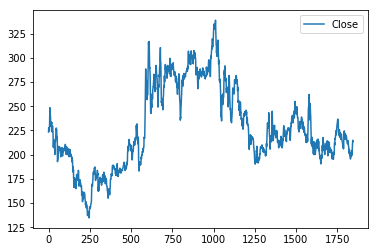

<Figure size 432x288 with 0 Axes>

In [27]:
data_csv[['Close']].plot()
plt.show()
plt.clf()

### Calculating the length of data to use

In [28]:
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(data_csv)-1))

# 80% of data will be of training
train_end = int(data_to_use*0.8)

total_data = len(data_csv)
print("Total Data Length:", total_data)

Total Data Length: 1846


### Arranging the data

In [29]:
start = total_data - data_to_use

# Currently doing prediction only for 1 step ahead
steps_to_predict = 1

#close, compund, neg, neu, pos, open, high, low, volume
# Order -> 8,1,2,3,4,5,6,7,9
yt = data_csv.iloc[start:total_data,8] #close
yt1 = data_csv.iloc[start:total_data,1] #compund
yt2 = data_csv.iloc[start:total_data,2] #neg
yt3 = data_csv.iloc[start:total_data,3] #neu
yt4 = data_csv.iloc[start:total_data,4] #pos
yt5 = data_csv.iloc[start:total_data,5] #open
yt6 = data_csv.iloc[start:total_data,6] #high
yt7 = data_csv.iloc[start:total_data,7] #low
vt = data_csv.iloc[start:total_data,9] #volume

print("yt head (close) :")
print(yt.head())

yt head (close) :
1    227.97
2    226.27
3    226.16
4    225.99
5    224.44
Name: Close, dtype: float64


### Shifting the data by 1

In [30]:
#shift next day close and next day compund
yt_ = yt.shift(-1) #shifted close
yt1_ = yt1.shift(-1) #shifted compund

#taking only: close, next_close, compund, next_compund, volume, open, high, low
data = pd.concat([yt, yt_, yt1, yt1_, vt, yt5, yt6, yt7], axis=1)
data.columns = ['yt', 'yt_', 'yt1', 'yt1_','vt', 'yt5', 'yt6', 'yt7']

data = data.dropna()
     
print(data[:10])

        yt     yt_     yt1    yt1_       vt     yt5     yt6     yt7
1   227.97  226.27 -0.6996 -0.9442  1601540  223.32  229.50  223.32
2   226.27  226.16 -0.9442 -0.7906  2181684  227.00  232.00  225.60
3   226.16  225.99 -0.7906 -0.5859  1034935  227.00  227.65  224.20
4   225.99  224.44 -0.5859 -0.9723  1247251  227.50  227.99  223.80
5   224.44  228.58 -0.9723 -0.9578   571792  227.50  228.00  223.50
6   228.58  238.68 -0.9578 -0.3818  1501995  225.25  229.29  223.61
7   238.68  248.46 -0.3818 -0.7184  4938671  229.00  239.85  229.00
8   248.46  243.35 -0.7184 -0.8720  3835913  240.00  250.48  238.50
9   243.35  244.64 -0.8720 -0.5994  1974180  249.25  250.25  242.10
10  244.64  239.77 -0.5994 -0.7506  1800665  245.35  245.35  239.55


### Separating data into x and y
**Approach:** Training the machine using ***compund, close price, and next_compund*** to predict ***next_close price***.

In [31]:
# target variable - closed price
# after shifting
y = data['yt_'] #next_close

# close, compund, next_compund, volume, open, high, low   
cols = ['yt', 'yt1', 'yt1_', 'vt', 'yt5', 'yt6', 'yt7']
x = data[cols]

### Preprocessing

In [32]:
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

### Train Test Split

In [33]:
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

X_train = X_train.reshape (X_train. shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

### RNN LSTM Model

In [34]:
batch_size = 32
nb_epoch = 100
neurons = 25
dropout = 0.1

seed = 2016
np.random.seed(seed)

model = Sequential ()
model.add(LSTM(neurons, return_sequences=True, activation='tanh', inner_activation='hard_sigmoid', input_shape=(len(cols), 1)))
model.add(Dropout(dropout))
model.add(LSTM(neurons, return_sequences=True,  activation='tanh'))
model.add(Dropout(dropout))
model.add(LSTM(neurons, activation='tanh'))
model.add(Dropout(dropout))

model.add(Dense(activity_regularizer=regularizers.l1(0.00001), output_dim=1, activation='linear'))
model.add(Activation('tanh'))

print(model.summary())

model.compile(loss='mean_squared_error' , optimizer='RMSprop')
model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1, validation_split=0.2)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 7, 25)             2700      
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 25)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 7, 25)             5100      
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 25)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 25)                5100      
_________________________________________________________________
dropout_6 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
__________

Epoch 65/100
1180/1180 [==============================] - 1s 864us/step - loss: 0.0049 - val_loss: 0.0023
Epoch 66/100
1180/1180 [==============================] - 1s 787us/step - loss: 0.0047 - val_loss: 0.0032
Epoch 67/100
1180/1180 [==============================] - 1s 857us/step - loss: 0.0047 - val_loss: 0.0021
Epoch 68/100
1180/1180 [==============================] - 1s 857us/step - loss: 0.0050 - val_loss: 0.0023
Epoch 69/100
1180/1180 [==============================] - 1s 883us/step - loss: 0.0045 - val_loss: 0.0019
Epoch 70/100
1180/1180 [==============================] - 1s 764us/step - loss: 0.0044 - val_loss: 0.0024
Epoch 71/100
1180/1180 [==============================] - 1s 905us/step - loss: 0.0048 - val_loss: 0.0035
Epoch 72/100
1180/1180 [==============================] - 1s 898us/step - loss: 0.0047 - val_loss: 0.0022
Epoch 73/100
1180/1180 [==============================] - 1s 926us/step - loss: 0.0045 - val_loss: 0.0022
Epoch 74/100
1180/1180 [======================

### Score Calculation

In [35]:
score_train = model.evaluate(X_train, y_train, batch_size =1)
score_test = model.evaluate(X_test, y_test, batch_size =1)
print("In train MSE = ", round( score_train ,4)) 
print("In test MSE = ", score_test )

367/367 [==============================] - 2s 5ms/step
In train MSE =  0.0024
In test MSE =  0.00275342355090613


### Saving model

In [36]:
model_json = model.to_json()
with open("model_rms100e_new.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("Saved_Model.h5")
print("Saved model to disk")

Saved model to disk


### Predicting on unseen data

Inputs: (None, 7, 1)
Outputs: (None, 1)
Actual input: (367, 7, 1)
Actual output: (367, 1)
prediction data:
[219.3167]
actual data
[[240.21     0.7351  -0.9849 ... 240.42   247.     234.5   ]
 [237.43    -0.9849  -0.3784 ... 241.     242.99   236.8   ]
 [233.46    -0.3784  -0.9716 ... 236.     237.88   232.62  ]
 ...
 [208.94    -0.8853  -0.9939 ... 206.     209.8    204.6   ]
 [212.82    -0.9939  -0.6908 ... 207.44   213.85   207.    ]
 [214.85    -0.6908   0.9178 ... 211.5    216.     210.5   ]]


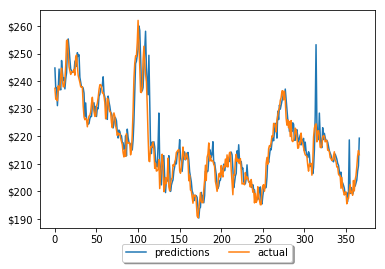

<Figure size 432x288 with 0 Axes>

In [37]:
pred = model.predict(X_test) 
pred = scaler_y.inverse_transform(np.array(pred).reshape((len(pred), 1)))

prediction_data = pred[-1]     

print ("Inputs: {}".format(model.input_shape))
print ("Outputs: {}".format(model.output_shape))
print ("Actual input: {}".format(X_test.shape))
print ("Actual output: {}".format(y_test.shape))

print ("prediction data:")
print (prediction_data)

print ("actual data")
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))
print (X_test)

#########################################################################
'''Plotting'''
plt.plot(pred, label="predictions")

y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len( y_test), 1)))
plt.plot([row[0] for row in y_test], label="actual")

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)

ax = plt.axes()
ax.yaxis.set_major_formatter(tick)
plt.show()
plt.clf()
